In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit

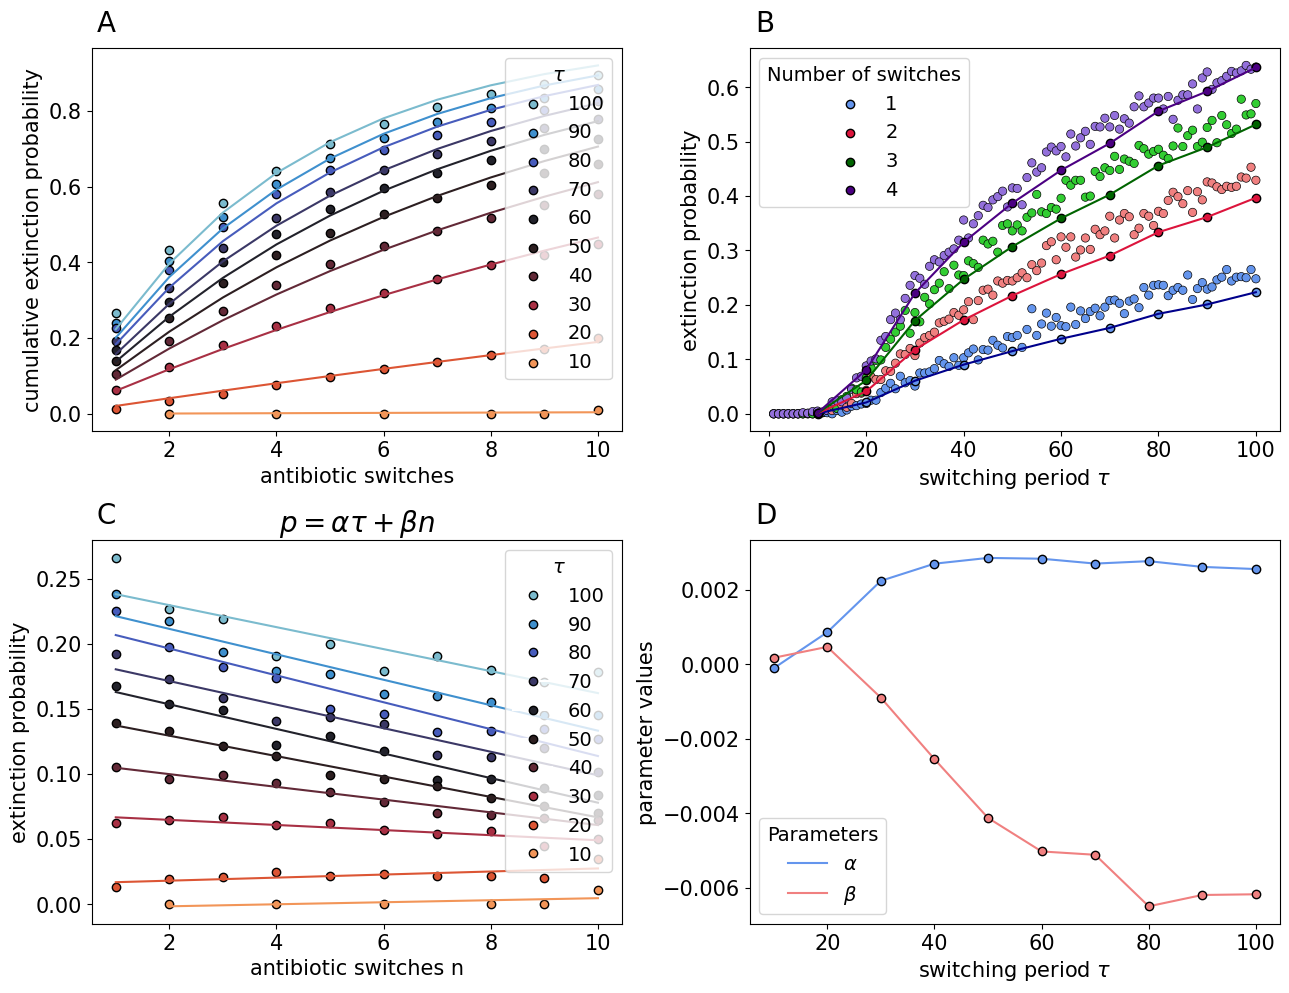

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(13, 10))

plt.subplot(2,2,1)

df = pd.read_csv('Geometric fit/geom_ext_rate.csv')
df['MaxTime'] = df['SeasonLength']*10 + 50
df['Dead'] = df['FinalTime'] < df['MaxTime']
df['Rounds'] = np.minimum(df['FinalTime'] // df['SeasonLength'] , 10)

dfext = df.sort_values(['SeasonLength', 'Rounds']).reset_index(drop=True)
dfext = dfext.groupby(['Dead', 'SeasonLength', 'Rounds']).count().reset_index()

dfext['cum'] = dfext.groupby(['Dead', 'SeasonLength'])['Trajectory'].cumsum()
dfext = dfext[dfext['Dead']==True]

dfext['ExtRate'] = dfext['cum'] / 10000

def geom_model(N, p):
    return 1 - (1 - p)**N

resultados = []

for season, grupo in dfext.groupby('SeasonLength'):
    N_vals = grupo['Rounds'].values
    P_vals = grupo['ExtRate'].values


    sigma_vals = 1 / N_vals
    
    # Ajustar el modelo
    try:
        popt, _ = curve_fit(geom_model, N_vals, P_vals, bounds=(0, 1))
        p_estimado = popt[0]

        popt, _ = curve_fit(geom_model, N_vals, P_vals, bounds=(0, 1),
                            sigma=sigma_vals,
                            absolute_sigma=False  # Pondera con los valores relativos
                           )
        p_estimado_p = popt[0]
    except RuntimeError:
        p_estimado = np.nan  # En caso de que no converja
        p_estimado_p = np.nan

    resultados.append({'SeasonLength': season, 'p_estimado': p_estimado, 'p_estimado_p':p_estimado_p})
    
df_geom = pd.DataFrame(resultados)


dfext = pd.merge(dfext, df_geom, on='SeasonLength')
dfext['P'] = 1 - (1-dfext['p_estimado'])**dfext['Rounds']
dfext['P_pesado'] = 1 - (1-dfext['p_estimado_p'])**dfext['Rounds']

orden = sorted(dfext['SeasonLength'].unique(), reverse=True)

#colors = plt.cm.icefire.colors
colors = sns.color_palette('icefire',len(df['SeasonLength'].unique()))
pltt = dict(zip(df['SeasonLength'].unique(), colors))

handles = []
labels = []

for i, (season_length, group) in enumerate(sorted(dfext.groupby('SeasonLength'), reverse=True)):
    plt.scatter(group['Rounds'], group['ExtRate'], ec='black', color=colors[i % len(colors)], label=season_length)
    plt.plot(group['Rounds'], group['P'], color=colors[i % len(colors)])

    # Guarda handles y labels para ordenar
    h = plt.Line2D([], [], marker='o', color='w', label=season_length,
                   markerfacecolor=colors[i % len(colors)], markeredgecolor='black')
    handles.append(h)
    labels.append(season_length)

# Ordenar handles y labels de mayor a menor
sorted_handles_labels = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_handles_labels)

#sns.scatterplot(data=dfext, x='Rounds', y='ExtRate', hue='SeasonLength',palette='icefire',ec='black',hue_order=orden)
#sns.lineplot(data=dfext, x='Rounds', y='P', hue='SeasonLength',palette='icefire',legend=False,hue_order=orden)
#sns.lineplot(data=dfext, x='Rounds', y='P_pesado', hue='SeasonLength',palette='viridis',legend=True)

plt.legend(fontsize=14, title_fontsize=14,loc='upper right',title=r'$\tau$')
plt.xlabel('antibiotic switches',fontsize=15)
plt.ylabel('cumulative extinction probability',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.subplot(2,2,2)

dfgeom = pd.read_csv('Geometric fit/estimated_p.csv')

for n in range(2,5):
    dfgeom['n'+str(n)] = 1- (1-dfgeom['p_estimado'])**n

df1 = pd.read_csv('Extinction curve/ext_rate_oneS.csv')
df1['Switch'] = [1]*df1.shape[0]
df2 = pd.read_csv('Extinction curve/ext_rate_twoS.csv')
df2['Switch'] = [2]*df2.shape[0]
df3 = pd.read_csv('Extinction curve/ext_rate_threeS.csv')
df3['Switch'] = [3]*df3.shape[0]
df4 = pd.read_csv('Extinction curve/ext_rate_fourS.csv')
df4['Switch'] = [4]*df4.shape[0]

df = pd.concat([df1, df2, df3, df4])

df['Dead'] = df['FinalTime'] < df['Switch']*df['SeasonLength'] + 50

dfext = df.groupby(['SeasonLength','Dead','Switch']).count().reset_index()

dfext = dfext[dfext['Dead']==False]
dfext['ExtRate'] = 1 - dfext['Trajectory'] / 1000


colordict = {
    1:'cornflowerblue',
    2:'lightcoral',
    3:'limegreen',
    4:'mediumpurple'
}

colordictfit = {
    1:'darkblue',
    2:'crimson',
    3:'darkgreen',
    4:'indigo'
}


sns.scatterplot(data=dfext, x='SeasonLength', y='ExtRate', hue='Switch', ec='black', 
                palette=colordict, legend=False,
               )

plt.scatter(df_geom['SeasonLength'], df_geom['p_estimado'], color='cornflowerblue', ec='black',label='1')
plt.plot(df_geom['SeasonLength'], df_geom['p_estimado'], color='darkblue')

for n in range(2,5):
    plt.scatter(dfgeom['SeasonLength'], dfgeom['n'+str(n)], ec='black', label=str(n), color=colordictfit[n])
    plt.plot(dfgeom['SeasonLength'], dfgeom['n'+str(n)], color=colordictfit[n])

plt.legend(title='Number of switches',fontsize=14,title_fontsize=14)
plt.xlabel('switching period '+r'$\tau$',fontsize=15)
plt.ylabel('extinction probability',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#.----------------------------------------------------------------------------------------------------------------
plt.subplot(2,2,3)

df = pd.read_csv('Geometric fit/geom_ext_rate.csv')
df['MaxTime'] = df['SeasonLength']*10 + 50
df['Dead'] = df['FinalTime'] < df['MaxTime']
df['Rounds'] = np.minimum(df['FinalTime'] // df['SeasonLength'] , 10)

dfext = df.sort_values(['SeasonLength', 'Rounds']).reset_index(drop=True)
dfext = dfext.groupby(['Dead', 'SeasonLength', 'Rounds']).count().reset_index()

dfext['cum'] = dfext.groupby(['Dead', 'SeasonLength'])['Trajectory'].cumsum()
dfext = dfext[dfext['Dead']==True]

dfext['N_obs'] = 10000 - (dfext['cum'] - dfext['Trajectory'])
dfext['p_ind'] = dfext['Trajectory']/dfext['N_obs']
dfext['p_cum'] = dfext.groupby(['Dead', 'SeasonLength'])['p_ind'].cumsum()

dfext['ExtRate'] = dfext['cum'] / 10000

#colors = plt.cm.icefire.colors
colors = sns.color_palette('icefire',len(df['SeasonLength'].unique()))
pltt = dict(zip(df['SeasonLength'].unique(), colors))

handles = []
labels = []

# Agrupar y graficar
for i, (season_length, group) in enumerate(sorted(dfext.groupby('SeasonLength'), reverse=True)):
    plt.scatter(group['Rounds'], group['p_ind'], ec='black', color=colors[i % len(colors)], label=season_length)
    
    x = group['Rounds']
    y = group['p_ind']
    coeffs = np.polyfit(x, y, deg=1)
    y_fit = np.polyval(coeffs, x)
    plt.plot(x, y_fit, color=colors[i % len(colors)])

    # Guarda handles y labels para ordenar
    h = plt.Line2D([], [], marker='o', color='w', label=season_length,
                   markerfacecolor=colors[i % len(colors)], markeredgecolor='black')
    handles.append(h)
    labels.append(season_length)

# Ordenar handles y labels de mayor a menor
sorted_handles_labels = sorted(zip(labels, handles), reverse=True)
sorted_labels, sorted_handles = zip(*sorted_handles_labels)

plt.legend(sorted_handles, sorted_labels, fontsize=14, title=r'$\tau$', title_fontsize=14,loc='upper right')
plt.xlabel('antibiotic switches n', fontsize=15)
plt.ylabel('extinction probability', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'$p=\alpha \tau + \beta n$', fontsize=20)

plt.subplot(2,2,4)

def geom_model_jerarquico(X, alpha, beta):
    N, tau = X
    p = alpha * tau + beta * N
    return 1 - (1 - p) ** N

resultados = []

# Asegúrate de que el nombre de la columna esté bien escrito
dfext['SeasonLength'] = dfext['SeasonLength']  # Corrige si antes era 'SeasonLenght'

for season, grupo in dfext.groupby('SeasonLength'):
    N_vals = grupo['Rounds'].values
    P_vals = grupo['ExtRate'].values
    tau_vals = grupo['SeasonLength'].values  # constante para el grupo

    try:
        # Ajustamos usando como input una tupla (N, tau)
        popt, _ = curve_fit(
            geom_model_jerarquico,
            (N_vals, tau_vals),
            P_vals,
            bounds=(-10, 10)
        )
        alpha_estimado, beta_estimado = popt
    except RuntimeError:
        alpha_estimado = np.nan
        beta_estimado = np.nan

    resultados.append({
        'SeasonLength': season,
        'alpha_estimado': alpha_estimado,
        'beta_estimado': beta_estimado
    })

# Convertimos resultados en DataFrame
df_geom = pd.DataFrame(resultados)
dfext = pd.merge(dfext, df_geom, on='SeasonLength')
# Calculamos p_estimado y P ajustado
dfext['p_estimado'] = dfext['SeasonLength'] * dfext['alpha_estimado'] + dfext['Rounds'] * dfext['beta_estimado']
dfext['P'] = 1 - (1 - dfext['p_estimado']) ** dfext['Rounds']

plt.plot(df_geom['SeasonLength'],df_geom['alpha_estimado'],label=r'$\alpha$',color='cornflowerblue')
plt.scatter(df_geom['SeasonLength'],df_geom['alpha_estimado'],ec='black',color='cornflowerblue',zorder=2)
plt.plot(df_geom['SeasonLength'],df_geom['beta_estimado'],label=r'$\beta$',color='lightcoral')
plt.scatter(df_geom['SeasonLength'],df_geom['beta_estimado'],ec='black',color='lightcoral',zorder=2)

plt.legend(fontsize=14,title='Parameters',title_fontsize=14)
plt.xlabel('switching period '+r'$\tau$',fontsize=15)
plt.ylabel('parameter values',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


axes = axes.flatten()
# Letras A, B, C, ...
letters = ['A','B','C','D','E','F']

for i, ax in enumerate(axes):
    # Agrega la letra en la esquina superior izquierda de cada subplot
    ax.text(
        0.01, 1.1, letters[i],                # posición relativa en el eje (0,0 es abajo izquierda)
        transform=ax.transAxes,                # usa coordenadas relativas al eje
        fontsize=20, va='top'
    )

plt.tight_layout()
#plt.savefig('Fig-supp_noneq-septiembre.png',dpi=300)
plt.show()

(*A*) Cumulative extinction probability over 10 treatment switches with different switching periods $\tau$. Points represent extinction probabilities estimated through simulation, while the solid line reflects a fit to a geometric distribution $1-(1-p)^n$.
(*B*) Estimation of the extinction probability for different number of antibiotic switches (represented with colors as indicated in the legend) using the fit of the geometrical model obtained in *A*.
(*C*) Linear fit to the extinction probability after each switch for the hierarchical geometric model.
(*D*) Estimated parameters for each tau $\tau$ in *C*.